In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [2]:
#import zipfile
#with zipfile.ZipFile('/content/knn.zip', 'r') as zip_ref:
#    zip_ref.extractall('/content/eeg/')

In [3]:
import plotly.graph_objects as go
import pandas as pd
import numpy as np
from scipy.interpolate import griddata
import re, os


Creating csv files dont run again if you already have the files

In [351]:
def create_csv(test_train, kde_knn, digit_uc13, bin_mul='binary'):

  path= ('/content/'+digit_uc13+'/'+kde_knn+'/')

  all_text = []
  files = []
  if digit_uc13=='digit':
    for filename in os.listdir(os.path.join(path, test_train)):
      files.append(os.path.join(path, test_train,filename))
      continue
  else:
    binary_or_multy = re.compile('(.*)binary(.*)\.txt') if bin_mul=='binary' else re.compile('(.*)multi(.*)\.txt')
    for patient in os.listdir(path):
      for filename in os.listdir(os.path.join(path, patient, test_train)):
        if binary_or_multy.match(filename):
            files.append(os.path.join(path,patient,test_train, filename))
            continue

  for file in files:
      with open(file) as f:
          #print(file)
          lines = f.readlines()
          macro_avg_reg = re.compile('(.*)macro avg(.*)')
          run_time_reg = re.compile('(.*)running time in seconds:(.*)')

          temp = []
          for line in lines:
              matches_avg = (macro_avg_reg.match(line))
              matches_run = run_time_reg.match(line)

              if matches_avg:
                  #print('Match found: ', matches_avg.group())
                  all = matches_avg.group().split()[2:]

                  kmeans_value_reg = re.compile('(.*)_kmeans_\d*')
                  pca_value_reg = re.compile('(.*)\d*_K_') if kde_knn=='knn' else re.compile('(.*)\d*_ba')
                  bandwidth_or_K_value_reg = re.compile('(.*)_K_\d*') if kde_knn=='knn' else re.compile('(.*)_bandwidth_\d*.\d*')

                  precision = (float(all[0]))
                  recall = (float(all[1]))
                  f1_score = (float(all[2]))
                  kmeans = int(kmeans_value_reg.match(file).group()[-4:])
                  pca = int(pca_value_reg.match(file).group()[-6:-3]) if digit_uc13=='digit' else int(pca_value_reg.match(file).group()[-5:-3])
                  bandwidth_or_K = float(bandwidth_or_K_value_reg.match(file).group()[-3:]) if kde_knn=='knn' else float(bandwidth_or_K_value_reg.match(file).group()[-5:])

                  if digit_uc13=='digit':
                    temp.append([kmeans, pca, bandwidth_or_K, precision, recall, f1_score])
                  else:
                    patient_reg = re.compile('(.*)chb\d*')
                    patient = patient_reg.match(file).group()[-5:]
                    temp.append([patient, kmeans, pca, bandwidth_or_K, precision, recall, f1_score])
              if matches_run:
                  #print('Match found: ', matches_run.group())
                  runtime = float(matches_run.group().split()[-1])
                  temp[0].append(runtime)
          all_text.append(temp[0][:])

  all_data_df = pd.DataFrame(data=all_text)
  #print(all_data_df)
  if digit_uc13=='digit':
      all_data_df = all_data_df.sort_values(by=[0,1,2], ascending=True)
      all_data_df.to_csv(digit_uc13+'_'+kde_knn+'_'+test_train+'.csv', index=False, header=False, sep=' ')
  else:
    all_data_df = all_data_df.sort_values(by=[0,1,2,3], ascending=True)
    all_data_df.to_csv(digit_uc13+'_'+bin_mul+'_'+kde_knn+'_'+test_train+'.csv', index=False, header=False, sep=' ')


In [352]:
create_csv('test','kde','digit')
create_csv('train','kde','digit')
create_csv('test','knn','digit')
create_csv('train','knn','digit')

create_csv('test','kde','uc13', 'binary')
create_csv('train','kde','uc13', 'binary')
create_csv('test','knn','uc13', 'binary')
create_csv('train','knn','uc13', 'binary')

create_csv('test','kde','uc13', 'multi')
create_csv('train','kde','uc13', 'multi')
create_csv('test','knn','uc13', 'multi')
create_csv('train','knn','uc13', 'multi')

# Kernel Density Estimation


## Digit dataset

In [4]:
def read_digit_data(file_path, variable='bandwidth'):
    df = pd.read_csv(file_path, sep=' ', header=None)     #macro avg
    df.columns = ['kmeans', 'PCA_components', variable, 'precision', 'recall', 'f1-score', 'runtime']
    return df

df_kde_test = read_digit_data("digit_kde_test.csv")
print(df_kde_test.head())

   kmeans  PCA_components  bandwidth  precision  recall  f1-score  runtime
0       0              37        0.1       0.94    0.91      0.92    3.608
1       0              37        0.2       0.97    0.97      0.97    3.501
2       0              37        0.5       0.97    0.97      0.97    3.338
3       0              37        1.0       0.97    0.97      0.97    3.233
4       0              37        2.0       0.92    0.91      0.92    3.321


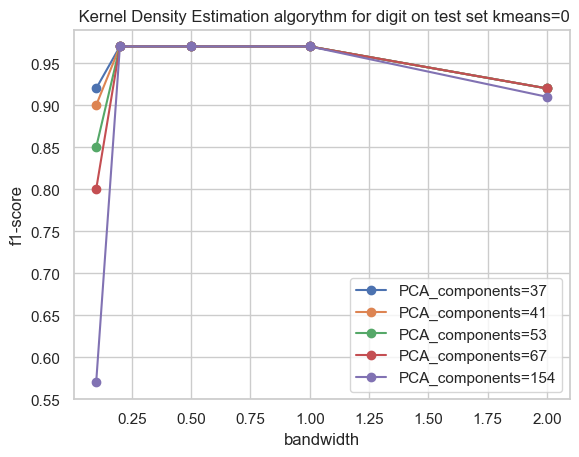

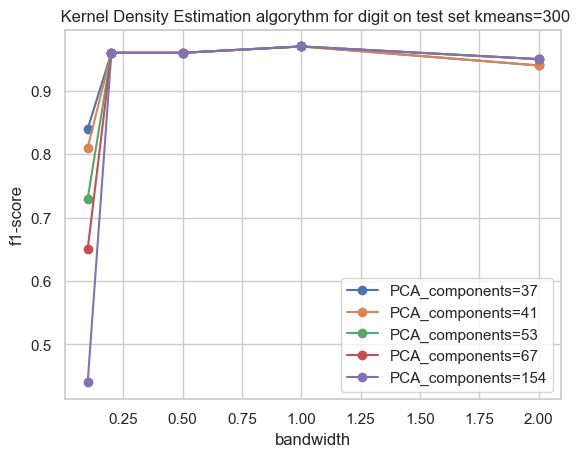

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_digit_f1_score_vs_bandwidth_diff_pca(df, title):
    sns.set(style="whitegrid")
    for kmean in df['kmeans'].unique():
      kmeans_subset_df = df[df['kmeans'] == kmean]
      for PCA_components in kmeans_subset_df['PCA_components'].unique():
          subset_df = kmeans_subset_df[kmeans_subset_df['PCA_components'] == PCA_components]

          plt.plot(subset_df[subset_df.columns[2]], subset_df['f1-score'], label=f'PCA_components={PCA_components}', marker='o')

      plt.xlabel(subset_df.columns[2])
      plt.ylabel('f1-score')
      plt.title(title+' kmeans='+str(kmean))

      plt.legend(title='PCA_components')
      plt.legend(loc='lower right')
      plt.show()

plot_digit_f1_score_vs_bandwidth_diff_pca(df_kde_test,' Kernel Density Estimation algorythm for digit on test set')


In [357]:
df_kde_train = read_digit_data("/content/digit_kde_train.csv")
df_kde_train.head()

,kmeans,PCA_components,bandwidth,precision,recall,f1-score,runtime
0,0,37,0.1,1.00,1.00,1.00,17.761
1,0,37,0.2,1.00,1.00,1.00,16.717
2,0,37,0.5,1.00,1.00,1.00,15.581
3,0,37,1.0,1.00,1.00,1.00,15.668
4,0,37,2.0,0.93,0.92,0.92,15.474


In [ ]:
plot_digit_f1_score_vs_bandwidth_diff_pca(df_kde_train, 'Kernel Density estimation algorythm for digit on train set')

In [6]:
def plot_digit_runtime_vs_f1_train_vs_test(df_train, df_test, title):
    sns.set(style="whitegrid")
    for kmean in df_train['kmeans'].unique():
      kmeans_subset_df_train = df_train[df_train['kmeans'] == kmean][['PCA_components','runtime', 'f1-score']]
      kmeans_subset_df_test = df_test[df_test['kmeans'] == kmean][['PCA_components','runtime', 'f1-score']]
      grouped_train = kmeans_subset_df_train.groupby('PCA_components')
      grouped_test = kmeans_subset_df_test.groupby('PCA_components')
      plt.plot(grouped_train.mean()['f1-score'], grouped_train.mean()['runtime'],label=f'Training Set', marker='o', color='blue')
      plt.plot(grouped_test.mean()['f1-score'], grouped_test.mean()['runtime'],label=f'Test Set', marker='o', color='orange')

      plt.xlabel('f1-score')
      plt.ylabel('runtime')
      plt.title(title+' kmeans='+str(kmean))
      plt.legend()
      plt.show()

plot_digit_runtime_vs_f1_train_vs_test(df_kde_train,df_kde_test,' Kernel Density Estimation algorythm for digit on train set runtime')


NameError: name 'df_kde_train' is not defined

In [360]:
def plot_test_vs_train_digit(df_test, df_train, title):
    '''
    for kmean in df_train['kmeans'].unique():
      kmeans_train_subset = df_train[df_train["kmeans"] == kmean]
      kmeans_test_subset = df_test[df_test["kmeans"] == kmean]


      for PCA_components in kmeans_train_subset['PCA_components'].unique():
          train_subset = kmeans_train_subset[kmeans_train_subset["PCA_components"] == PCA_components]
          test_subset = kmeans_test_subset[kmeans_test_subset["PCA_components"] == PCA_components]

          plt.plot(train_subset[train_subset.columns[2]], train_subset["f1-score"], label=f'Training Set pca={PCA_components}', marker='o', color='blue')

          plt.plot(test_subset[test_subset.columns[2]], test_subset["f1-score"], label=f'Test Set pca={PCA_components}', marker='o', color='orange')

      plt.xlabel(kmeans_train_subset.columns[2])
      plt.ylabel('f1-score')
      plt.title(title +' kmean='+str(kmean))

      plt.legend()
      plt.show()
      '''

    #avg
    for kmean in df_train['kmeans'].unique():
      kmeans_train_subset = df_train[df_train["kmeans"] == kmean]
      kmeans_test_subset = df_test[df_test["kmeans"] == kmean]


      grouped_train = kmeans_train_subset.groupby('PCA_components')
      grouped_test = kmeans_test_subset.groupby('PCA_components')
      #print(grouped_train.mean().index)
      plt.plot(list(grouped_train.mean().index), grouped_train.mean()['f1-score'], label=f'Training Set', marker='o', color='blue')
      plt.plot(list(grouped_test.mean().index), grouped_test.mean()['f1-score'], label=f'Test Set', marker='o', color='orange')

      plt.xlabel('PCA_components')
      plt.ylabel('f1-score')
      plt.title(title +' kmean='+str(kmean))

      plt.legend()
      plt.show()






In [ ]:
plot_test_vs_train_digit(df_kde_test, df_kde_train, 'Kernel Density Estimation for digit')

## UC13 binary

In [7]:
def read_uc13_data(path, value='bandwidth'):
    df = pd.read_csv(path, sep=' ', header=None)
    df.columns = ['patient', 'kmeans', 'pca', value, 'precision', 'recall', 'f1-score','runtime']
    return df

df_uc13_bin_kde_test = read_uc13_data('/content/uc13_binary_kde_test.csv')
df_uc13_bin_kde_test.head()

FileNotFoundError: [Errno 2] No such file or directory: '/content/uc13_binary_kde_test.csv'

In [364]:
df_uc13_bin_kde_train = read_uc13_data('/content/uc13_binary_kde_train.csv')
df_uc13_bin_kde_train.head()

,patient,kmeans,pca,bandwidth,precision,recall,f1-score,runtime
0,chb03,0,14,0.1,1.0,1.0,1.0,74.827
1,chb03,0,14,0.2,1.0,1.0,1.0,75.808
2,chb03,0,14,0.5,1.0,1.0,1.0,76.607
3,chb03,0,14,1.0,1.0,1.0,1.0,74.658
4,chb03,0,14,2.0,1.0,1.0,1.0,75.657


In [8]:
import plotly.graph_objects as go
import numpy as np
from scipy.interpolate import griddata

def plot_uc13_3d_kmeans_k_or_bandwidth_avg_f1_score(df, title):
    k_or_bandwidth = df.columns[3]
    average_df = df.groupby(['kmeans',k_or_bandwidth], as_index=False)['f1-score'].mean()

    kmeans = np.unique(average_df['kmeans'])
    k_or_b = np.unique(average_df[k_or_bandwidth])
    kmeans, k_or_b = np.meshgrid(kmeans, k_or_b)

    Z = griddata((average_df['kmeans'], average_df[k_or_bandwidth]), average_df['f1-score'],(kmeans, k_or_b), method='cubic')


    fig = go.Figure(go.Surface(x=kmeans,y=k_or_b,z=Z))

    fig.update_layout(scene=dict(
                        xaxis_title='kmeans',
                        yaxis_title=k_or_bandwidth,
                        zaxis_title='Average F1-Score'),
                        scene_camera=dict(up=dict(x=0, y=0, z=1),
                        center=dict(x=0, y=0, z=0),
                        eye=dict(x=1.25, y=1.25, z=1.25)),
                        width=850,
                        height=800,
                        title_font_size=30)

    fig.update_layout(title=title)
    fig.show()


def plot_uc13_2d_kmeans_avg_f1_score(df, title):
    #print(df)
    k_or_bandwidth = df.columns[3]
    average_df = df.groupby(['kmeans',k_or_bandwidth], as_index=False)['f1-score'].mean()
    for k_or_b in np.unique(average_df[k_or_bandwidth]):
      subset_df = average_df[average_df[k_or_bandwidth] == k_or_b]

      plt.plot(subset_df['kmeans'], subset_df['f1-score'], label=f'{k_or_bandwidth}={k_or_b}', marker='o')

    plt.xlabel('kmeans')
    plt.ylabel('f1-score')
    plt.title(title)

    plt.legend(title=k_or_bandwidth)
    plt.legend(loc='lower right')
    plt.show()

def plot_uc13_2d_kmeans_fix_k_or_bandwidth_each_patient_avg_f1_score(df, k_or_b=2, title=''):
    k_or_bandwidth = df.columns[3]
    df = df[df[k_or_bandwidth] == k_or_b]
    average_df = df.groupby(['patient','kmeans'], as_index=False)['f1-score'].mean()
    #print(average_df)
    for patient_id in np.unique(average_df['patient']):
      subset_df = average_df[average_df['patient'] == patient_id]

      plt.plot(subset_df['kmeans'], subset_df['f1-score'], label=f'patient_id={patient_id}', marker='o')

    plt.xlabel('Kmeans')
    plt.ylabel('f1-score')
    plt.title(title)

    plt.legend(title='patient')
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=5)
    plt.show()


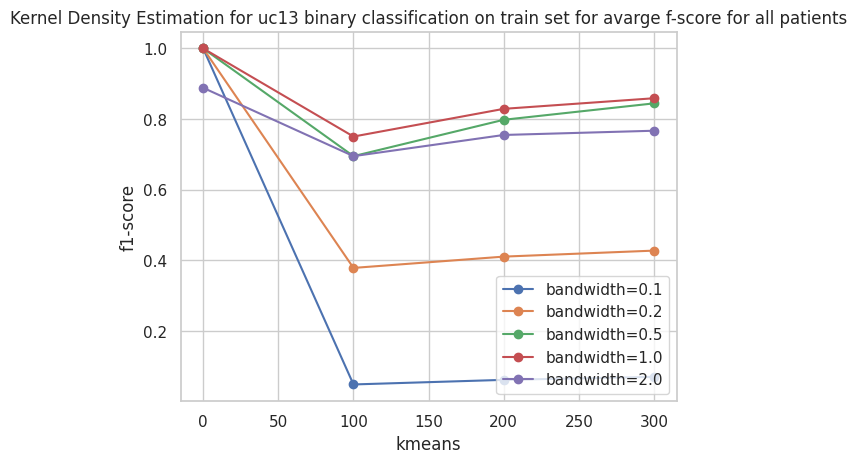

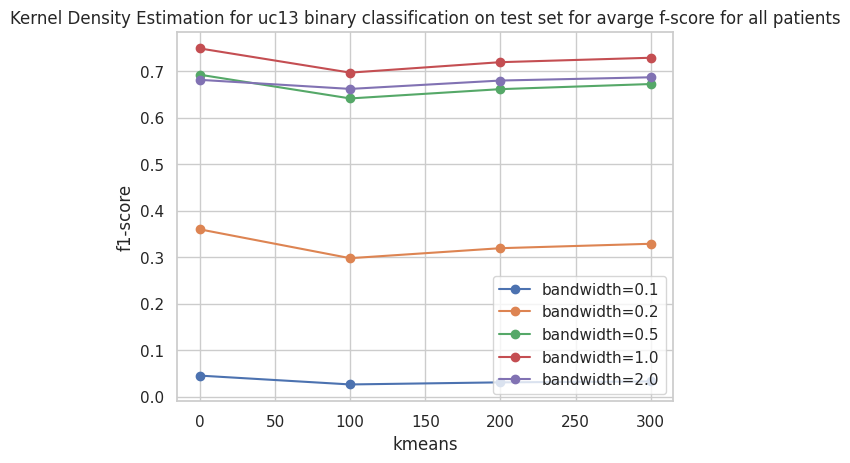

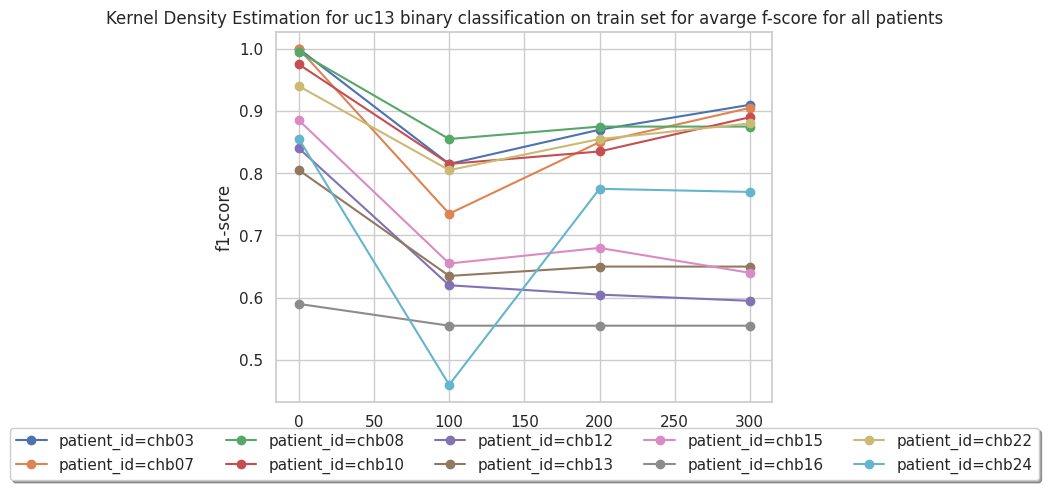

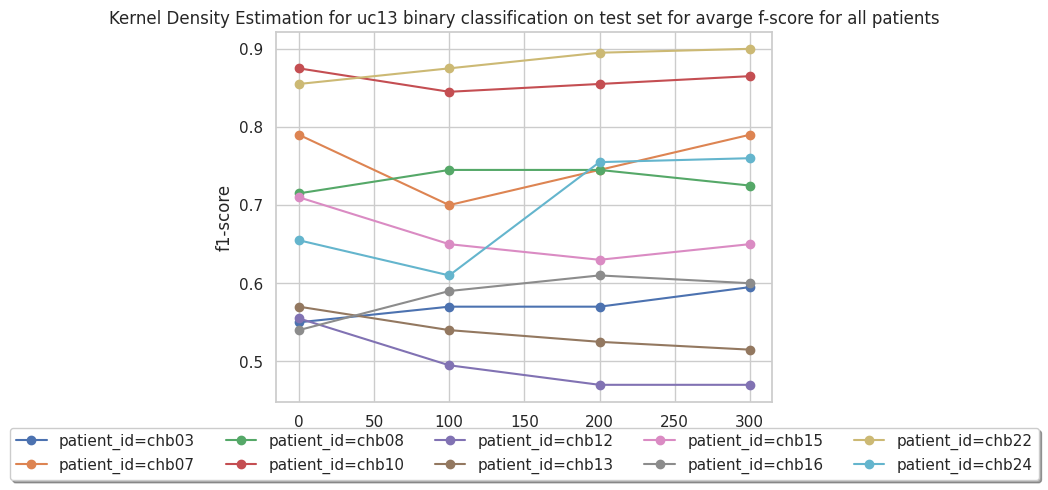

In [366]:
plot_uc13_3d_kmeans_k_or_bandwidth_avg_f1_score(df_uc13_bin_kde_train, 'Kernel Density Estimation for uc13 binary classification on train set for avarge f-score for all patients')
plot_uc13_3d_kmeans_k_or_bandwidth_avg_f1_score(df_uc13_bin_kde_test, 'Kernel Density Estimation for uc13 binary classification on test set for avarge f-score for all patients')
plot_uc13_2d_kmeans_avg_f1_score(df_uc13_bin_kde_train, 'Kernel Density Estimation for uc13 binary classification on train set for avarge f-score for all patients')
plot_uc13_2d_kmeans_avg_f1_score(df_uc13_bin_kde_test, 'Kernel Density Estimation for uc13 binary classification on test set for avarge f-score for all patients')
plot_uc13_2d_kmeans_fix_k_or_bandwidth_each_patient_avg_f1_score(df_uc13_bin_kde_train, 2,'Kernel Density Estimation for uc13 binary classification on train set for avarge f-score for all patients')
plot_uc13_2d_kmeans_fix_k_or_bandwidth_each_patient_avg_f1_score(df_uc13_bin_kde_test, 2, 'Kernel Density Estimation for uc13 binary classification on test set for avarge f-score for all patients')


## UC13 Multi

In [368]:
df_uc13_multi_kde_test = read_uc13_data('/content/uc13_multi_kde_test.csv')
df_uc13_multi_kde_train = read_uc13_data('/content/uc13_multi_kde_train.csv')
df_uc13_multi_kde_test.head()
df_uc13_multi_kde_test.head()

,patient,kmeans,pca,bandwidth,precision,recall,f1-score,runtime
0,chb03,0,14,0.1,0.00,0.17,0.00,39.278
1,chb03,0,14,0.2,0.17,0.21,0.07,38.149
2,chb03,0,14,0.5,0.21,0.30,0.20,37.981
3,chb03,0,14,1.0,0.21,0.21,0.21,37.721
4,chb03,0,14,2.0,0.22,0.23,0.21,38.058


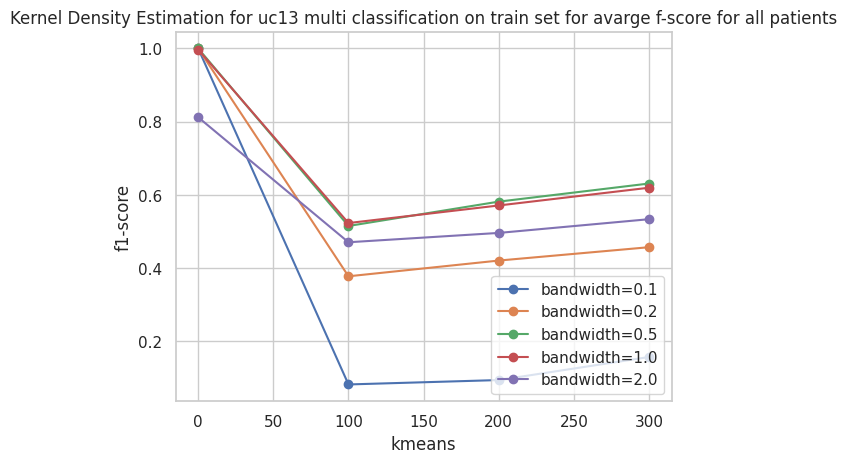

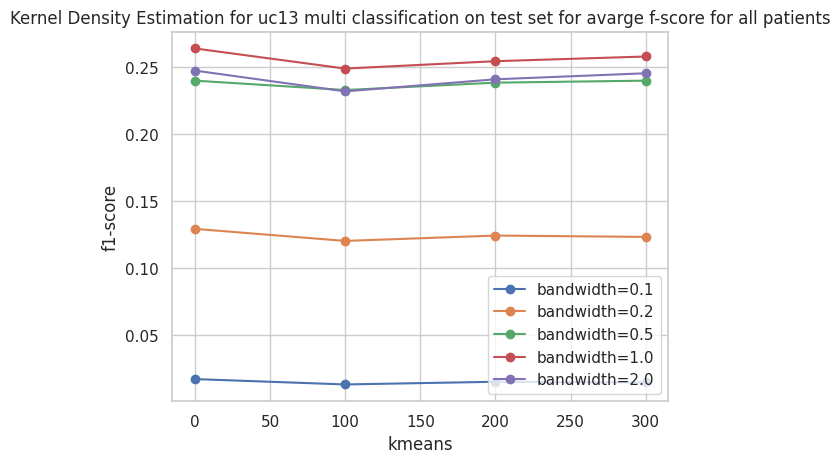

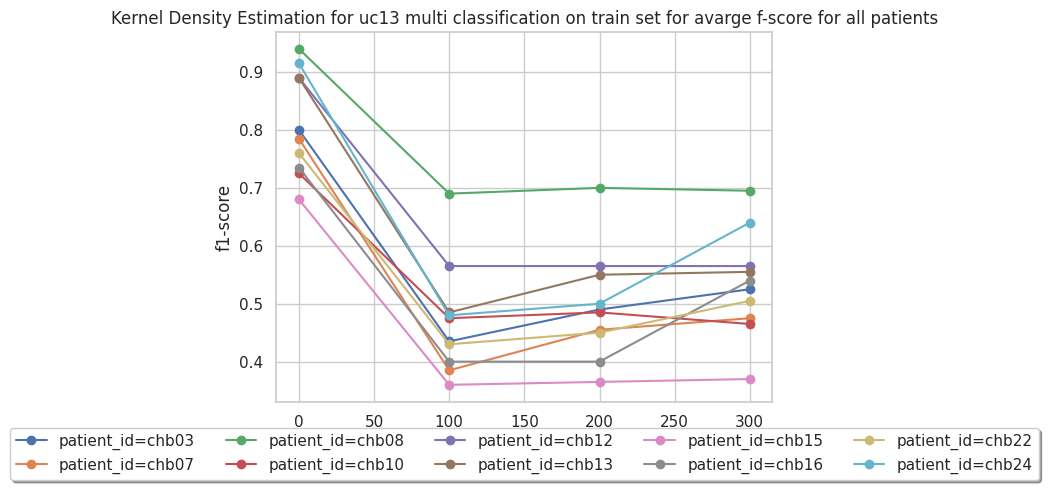

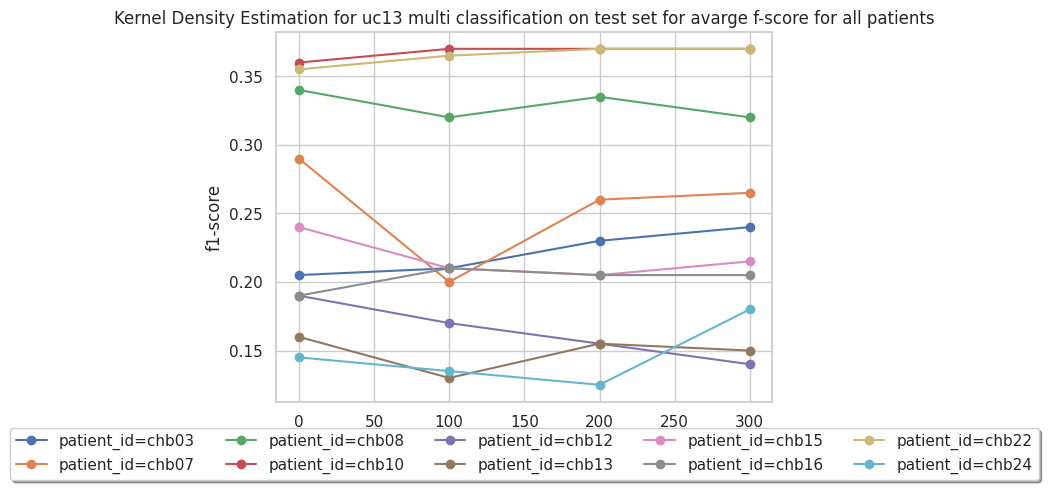

In [369]:
plot_uc13_3d_kmeans_k_or_bandwidth_avg_f1_score(df_uc13_multi_kde_train, 'Kernel Density Estimation for uc13 multi classification on train set for avarge f-score for all patients')
plot_uc13_3d_kmeans_k_or_bandwidth_avg_f1_score(df_uc13_multi_kde_test, 'Kernel Density Estimation for uc13 multi classification on test set for avarge f-score for all patients')
plot_uc13_2d_kmeans_avg_f1_score(df_uc13_multi_kde_train, 'Kernel Density Estimation for uc13 multi classification on train set for avarge f-score for all patients')
plot_uc13_2d_kmeans_avg_f1_score(df_uc13_multi_kde_test, 'Kernel Density Estimation for uc13 multi classification on test set for avarge f-score for all patients')
plot_uc13_2d_kmeans_fix_k_or_bandwidth_each_patient_avg_f1_score(df_uc13_multi_kde_train, 2,'Kernel Density Estimation for uc13 multi classification on train set for avarge f-score for all patients')
plot_uc13_2d_kmeans_fix_k_or_bandwidth_each_patient_avg_f1_score(df_uc13_multi_kde_test, 2,'Kernel Density Estimation for uc13 multi classification on test set for avarge f-score for all patients')


# KNN

## Digit dataset

In [6]:
df_knn_test = read_digit_data("digit_knn_test.csv", 'K')
df_knn_test.head()

,kmeans,PCA_components,K,precision,recall,f1-score,runtime
0,0,37,3.0,0.98,0.97,0.97,4.266
1,0,37,5.0,0.97,0.97,0.97,4.273
2,0,37,7.0,0.97,0.97,0.97,4.233
3,0,37,9.0,0.97,0.97,0.97,4.605
4,0,37,11.0,0.97,0.97,0.97,4.688


In [7]:
df_knn_train = read_digit_data("digit_knn_train.csv", 'K')
df_knn_train.head()

,kmeans,PCA_components,K,precision,recall,f1-score,runtime
0,0,37,3.0,0.99,0.99,0.99,22.430
1,0,37,5.0,0.99,0.99,0.99,22.021
2,0,37,7.0,0.98,0.98,0.98,22.713
3,0,37,9.0,0.98,0.98,0.98,23.372
4,0,37,11.0,0.98,0.98,0.98,24.875


In [ ]:
plot_digit_f1_score_vs_bandwidth_diff_pca(df_knn_train, 'KNN algorythm for digit on train set')


In [ ]:
plot_digit_f1_score_vs_bandwidth_diff_pca(df_knn_test, 'KNN algorythm for digit on test set')


In [ ]:
plot_test_vs_train_digit(df_knn_test, df_knn_train, 'KNN for digit for best')


In [9]:
def plot_kmeans_k_vs_runtime(df, title, pca, pca_name="PCA_components"):
    df_filtered = df[df[pca_name] == pca]

    kmeans = np.unique(df_filtered['kmeans'])
    k = np.unique(df_filtered['K'])
    kmeans, k = np.meshgrid(kmeans, k)
                        
    Z = griddata((df_filtered['kmeans'], df_filtered['K']), df_filtered['runtime'],(kmeans, k), method='cubic')

    fig = go.Figure(go.Surface(x=kmeans,y=k,z=Z))

    fig.update_layout(scene=dict(
                        xaxis_title='kmeans',
                        yaxis_title='k',
                        zaxis_title='Runtime'),
                        scene_camera=dict(up=dict(x=0, y=0, z=1),
                        center=dict(x=0, y=0, z=0),
                        eye=dict(x=1.25, y=1.25, z=1.25)),
                        width=850,
                        height=800,
                        title_font_size=30)

    fig.update_layout(title=f"{title} pca={pca}")
    fig.show()

def plot_kmeans_vs_runtime_f1(df, title, pca, pca_name="PCA_components"):
    df_filtered = df[df[pca_name] == pca]
    df_filtered = df_filtered.groupby(['kmeans'], as_index=False)['f1-score', 'runtime'].mean() # average f-1 score for all k
    
    fig, ax1 = plt.subplots()

    color = 'tab:red'
    ax1.set_xlabel('kmeans')
    ax1.set_ylabel('f1-score', color=color)
    ax1.plot(df_filtered['kmeans'], df_filtered['f1-score'], color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'tab:blue'
    ax2.set_ylabel('runtime', color=color)
    ax2.plot(df_filtered['kmeans'], df_filtered['runtime'], color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.title(f"{title}, pca={pca}")
    
    plt.show()

    

/tmp/ipykernel_20898/3691161020.py:28: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



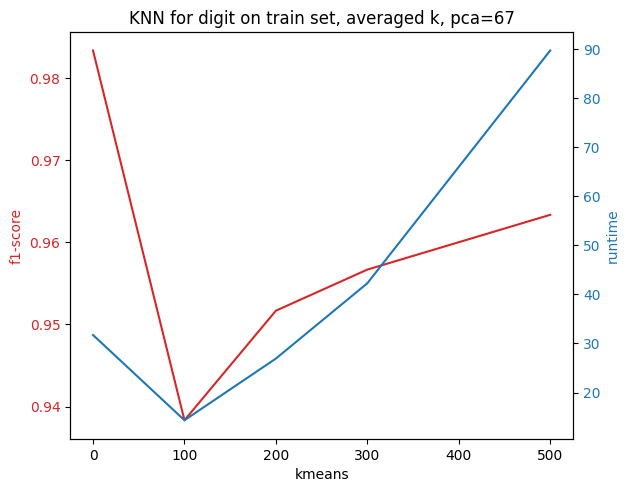

In [26]:
# for pca in df_knn_test['PCA_components'].unique():
#     plot_kmeans_k_vs_runtime(df_knn_train, 'Runtime for KNN on digit train set', pca)

plot_kmeans_k_vs_runtime(df_knn_train, 'Runtime for KNN on digit train set', 67)
plot_kmeans_vs_runtime_f1(df_knn_train, 'KNN for digit on train set, averaged k', 67)

/tmp/ipykernel_20898/1215976345.py:28: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



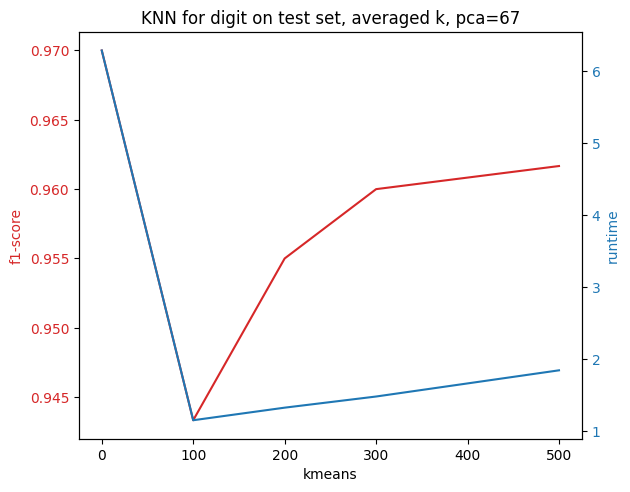

In [20]:
# for pca in df_knn_test['PCA_components'].unique():
#     plot_kmeans_k_vs_runtime(df_knn_test, 'Runtime for KNN on digit test set', pca)

plot_kmeans_k_vs_runtime(df_knn_test, 'Runtime for KNN on digit test set', 67)
plot_kmeans_vs_runtime_f1(df_knn_test, 'KNN for digit on test set, averaged k', 67)

In [ ]:
plot_digit_runtime_vs_f1_train_vs_test(df_knn_train, df_knn_test,' KNN algorythm for digit on train set runtime')


## UC13 binary

In [16]:
df_uc13_bin_knn_train = read_uc13_data('uc13_binary_knn_train.csv', 'K')
df_uc13_bin_knn_test = read_uc13_data('uc13_binary_knn_test.csv', 'K')
df_uc13_bin_knn_test.head()

,patient,kmeans,pca,K,precision,recall,f1-score,runtime
0,chb03,0,14,3.0,0.58,0.56,0.57,24.197
1,chb03,0,14,5.0,0.58,0.56,0.57,26.317
2,chb03,0,14,7.0,0.58,0.56,0.57,25.741
3,chb03,0,14,9.0,0.57,0.56,0.56,25.904
4,chb03,0,14,11.0,0.57,0.57,0.57,25.177


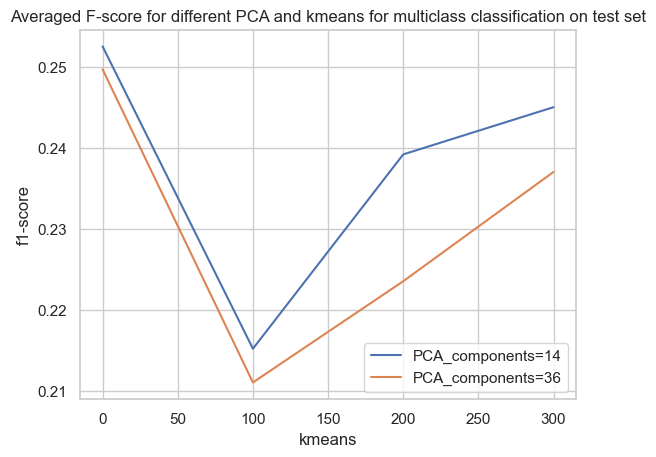

In [23]:
df = df_uc13_multi_knn_test 
sns.set(style="whitegrid")

for PCA_components in df['pca'].unique():
    subset_df = df[df['pca'] == PCA_components]
    subset_df = subset_df.groupby(["kmeans"], as_index=False)['f1-score'].mean()

    plt.plot(subset_df["kmeans"], subset_df['f1-score'], label=f'PCA_components={PCA_components}')

plt.xlabel("kmeans")
plt.ylabel('f1-score')
plt.title(f'Averaged F-score for different PCA and kmeans for multiclass classification on test set')

plt.legend(title='PCA_components')
plt.legend(loc='lower right')
plt.show()


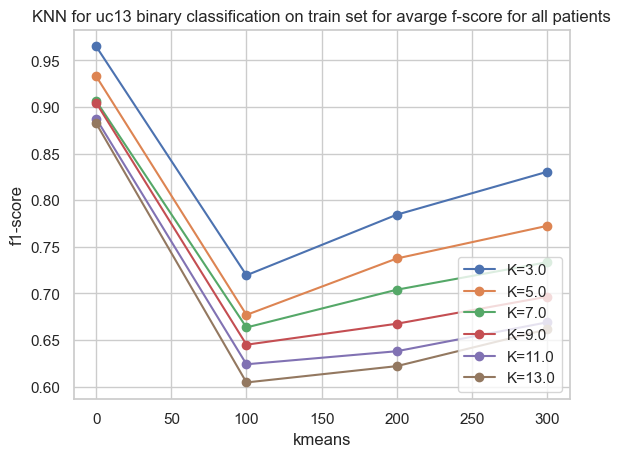

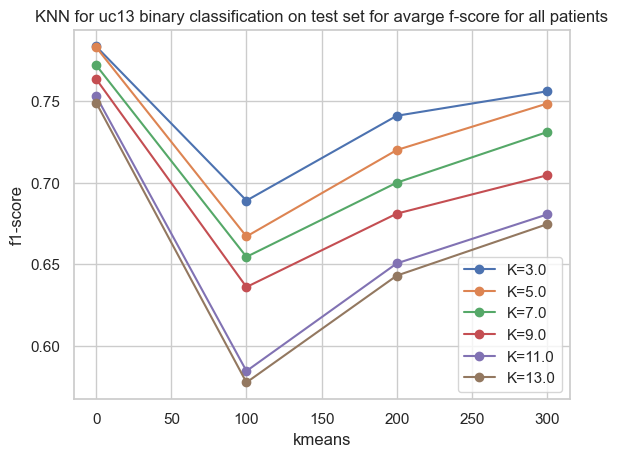

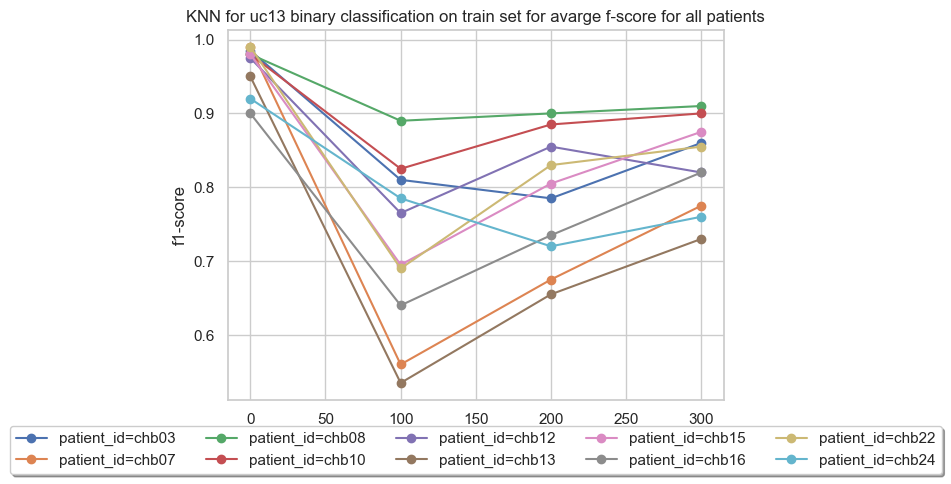

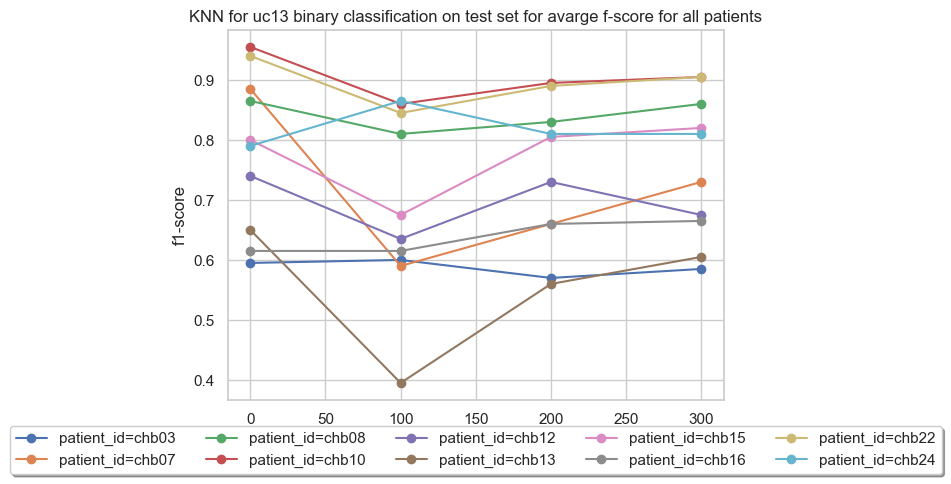

In [12]:
plot_uc13_3d_kmeans_k_or_bandwidth_avg_f1_score(df_uc13_bin_knn_train, 'KNN for uc13 binary classification on train set for avarge f-score for all patients')
plot_uc13_3d_kmeans_k_or_bandwidth_avg_f1_score(df_uc13_bin_knn_test, 'KNN for uc13 binary classification on test set for avarge f-score for all patients')
plot_uc13_2d_kmeans_avg_f1_score(df_uc13_bin_knn_train, 'KNN for uc13 binary classification on train set for avarge f-score for all patients')
plot_uc13_2d_kmeans_avg_f1_score(df_uc13_bin_knn_test, 'KNN for uc13 binary classification on test set for avarge f-score for all patients')
plot_uc13_2d_kmeans_fix_k_or_bandwidth_each_patient_avg_f1_score(df_uc13_bin_knn_train, 3,'KNN for uc13 binary classification on train set for avarge f-score for all patients')
plot_uc13_2d_kmeans_fix_k_or_bandwidth_each_patient_avg_f1_score(df_uc13_bin_knn_test, 3,'KNN for uc13 binary classification on test set for avarge f-score for all patients')


/tmp/ipykernel_20898/2484948311.py:28: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



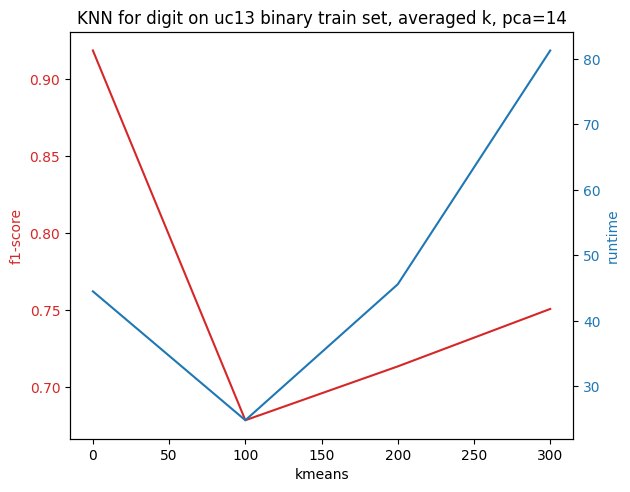

/tmp/ipykernel_20898/2484948311.py:28: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



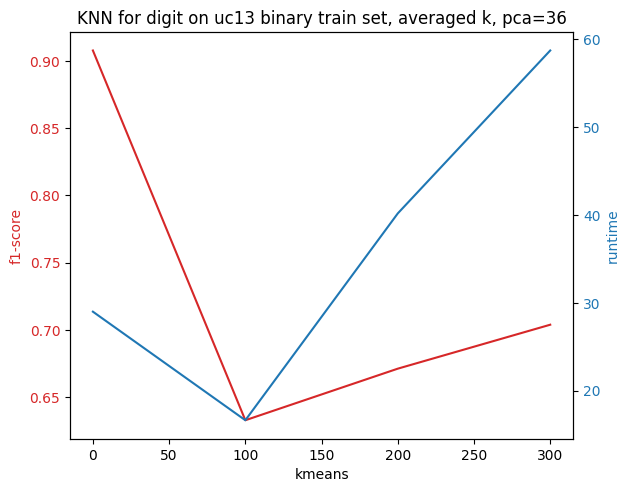

In [33]:
for pca in df_uc13_bin_knn_train['pca'].unique():
    plot_kmeans_k_vs_runtime(df_uc13_bin_knn_train, 'Runtime for KNN on uc13 binary train set', pca, "pca")
    plot_kmeans_vs_runtime_f1(df_uc13_bin_knn_train, 'KNN for digit on uc13 binary train set, averaged k', pca, "pca")

/tmp/ipykernel_20898/2484948311.py:28: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



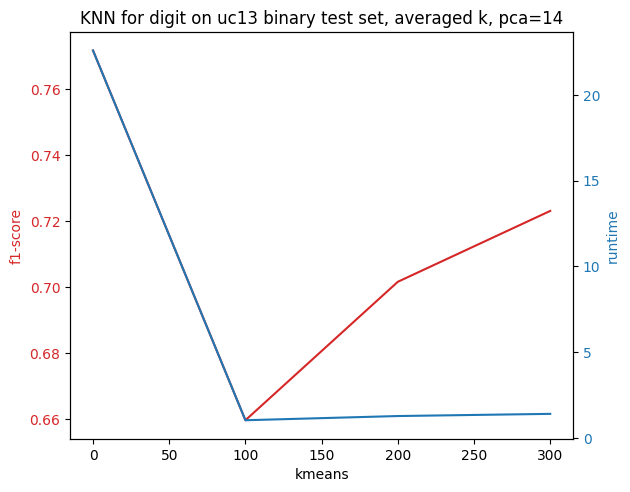

/tmp/ipykernel_20898/2484948311.py:28: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



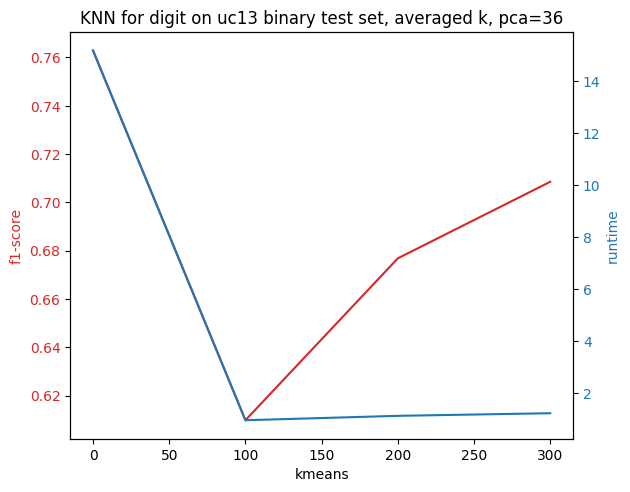

In [35]:
for pca in df_uc13_bin_knn_test['pca'].unique():
    plot_kmeans_k_vs_runtime(df_uc13_bin_knn_test, 'Runtime for KNN on uc13 binary test set', pca, "pca")
    plot_kmeans_vs_runtime_f1(df_uc13_bin_knn_test, 'KNN for digit on uc13 binary test set, averaged k', pca, "pca")

## UC13 Multi

In [22]:
df_uc13_multi_knn_train = read_uc13_data('uc13_multi_knn_train.csv', 'K')
df_uc13_multi_knn_test = read_uc13_data('uc13_multi_knn_test.csv', 'K')
df_uc13_multi_knn_test.head()
df_uc13_multi_knn_test.head()

,patient,kmeans,pca,K,precision,recall,f1-score,runtime
0,chb03,0,14,3.0,0.22,0.19,0.19,25.814
1,chb03,0,14,5.0,0.22,0.19,0.19,26.176
2,chb03,0,14,7.0,0.22,0.19,0.19,26.421
3,chb03,0,14,9.0,0.22,0.19,0.19,26.116
4,chb03,0,14,11.0,0.22,0.19,0.19,25.342


In [18]:
plot_uc13_3d_kmeans_k_or_bandwidth_avg_f1_score(df_uc13_multi_knn_train, 'KNN for uc13 multi classification on train set for avarge f-score for all patients')
plot_uc13_3d_kmeans_k_or_bandwidth_avg_f1_score(df_uc13_multi_knn_test, 'KNN for uc13 multi classification on test set for avarge f-score for all patients')
# plot_uc13_2d_kmeans_avg_f1_score(df_uc13_multi_knn_train, 'KNN for uc13 multi classification on train set for avarge f-score for all patients')
# plot_uc13_2d_kmeans_avg_f1_score(df_uc13_multi_knn_test, 'KNN for uc13 multi classification on test set for avarge f-score for all patients')
# plot_uc13_2d_kmeans_fix_k_or_bandwidth_each_patient_avg_f1_score(df_uc13_multi_knn_train, 3,'KNN for uc13 multi classification on train set for avarge f-score for all patients')
# plot_uc13_2d_kmeans_fix_k_or_bandwidth_each_patient_avg_f1_score(df_uc13_multi_knn_test, 3,'KNN for uc13 multi classification on test set for avarge f-score for all patients')


/tmp/ipykernel_5924/2484948311.py:28: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



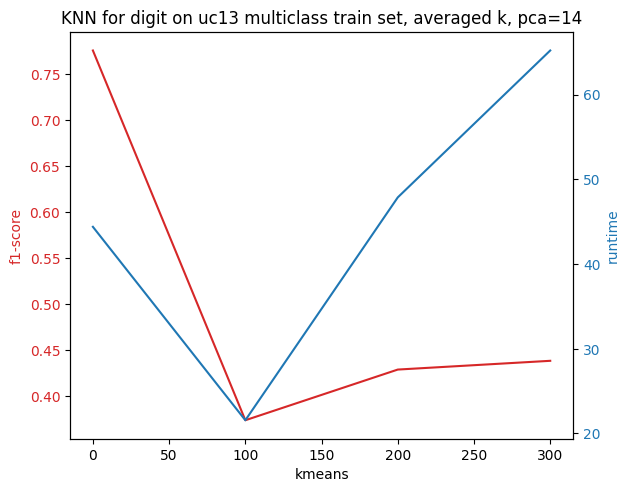

/tmp/ipykernel_5924/2484948311.py:28: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



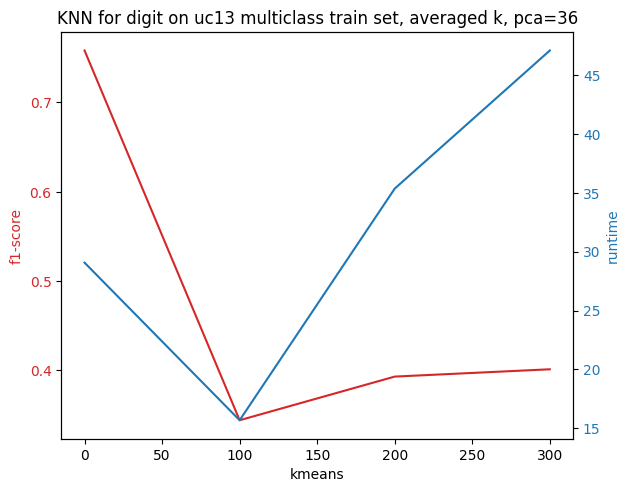

In [12]:
for pca in df_uc13_multi_knn_train['pca'].unique():
    plot_kmeans_k_vs_runtime(df_uc13_multi_knn_train, 'Runtime for KNN on uc13 multiclass train set', pca, "pca")
    plot_kmeans_vs_runtime_f1(df_uc13_multi_knn_train, 'KNN for digit on uc13 multiclass train set, averaged k', pca, "pca")

/tmp/ipykernel_5924/2484948311.py:28: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



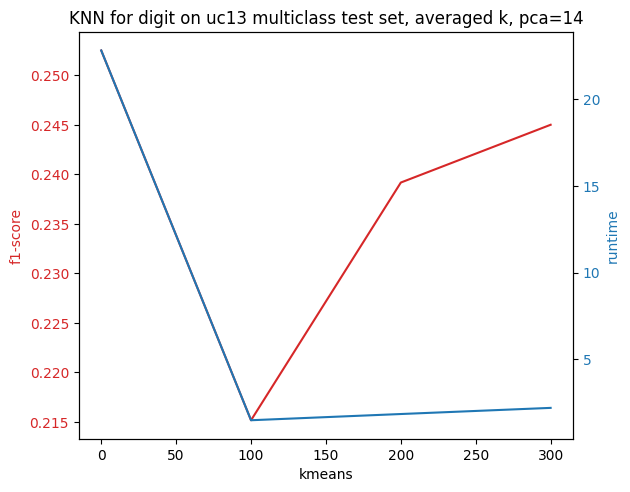

/tmp/ipykernel_5924/2484948311.py:28: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



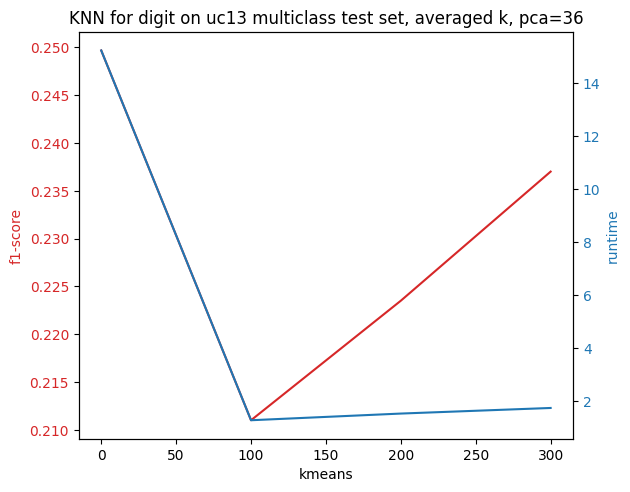

In [11]:
for pca in df_uc13_multi_knn_test['pca'].unique():
    plot_kmeans_k_vs_runtime(df_uc13_multi_knn_test, 'Runtime for KNN on uc13 multiclass test set', pca, "pca")
    plot_kmeans_vs_runtime_f1(df_uc13_multi_knn_test, 'KNN for digit on uc13 multiclass test set, averaged k', pca, "pca")